In [8]:
import sqlite3
import pandas as pd
import os

with sqlite3.connect(r"C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\raw_data\rasmus_classification_muon_3neutrino_3mio.db") as con:
    df = pd.read_sql("SELECT * FROM truth LIMIT 10000",con)

In [6]:
df.columns

Index(['event_no', 'energy_log10', 'time', 'position_x', 'position_y',
       'position_z', 'direction_x', 'direction_y', 'direction_z', 'azimuth',
       'zenith', 'pid', 'interaction_type', 'muon_track_length',
       'stopped_muon'],
      dtype='object')

In [14]:
row.energy_log10

-1.715544192070194

In [15]:
new_db = 'Muon_test_unscaled.db'
new_path = r'C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\raw_data'
with sqlite3.connect(os.path.join(new_path,new_db)) as con:
    cursor = con.cursor()
    query = """ CREATE TABLE IF NOT EXISTS truth (
                event_no INTEGER PRIMARY KEY NOT NULL,
                energy_log10 REAL NOT NULL
                ) """
    cursor.execute(query)
    
    for index, row in df.iterrows():
        cursor.execute("INSERT INTO truth (event_no, energy_log10) VALUES (?,?)", (row.event_no, row.energy_log10))

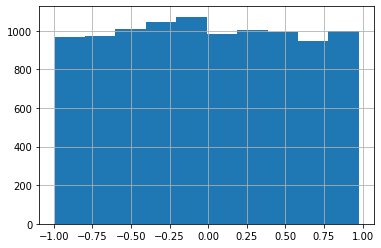

In [5]:
df.azimuth.hist()

# Delete above!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib notebook

In [16]:
# df = pd.read_pickle(r'C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\predictions\legacy_muon_angle_pred.pkl')
# df = df*180/np.pi


df = pd.read_csv(r'C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\predictions\Muon_Angle_m21_222t_1500k_MC_predictions.csv')
def Omega(azp,zep,azt,zet):
    s1 = np.sin( zet + azt - azp )
    s2 = np.sin( zet - azt + azp )
    c1 = np.cos( zet - zep )
    c2 = np.cos( zet + zep )
    return np.arccos(0.5*np.abs(np.sin(zep))*( s1 + s2 ) + 0.5*(c1 + c2))*180/np.pi
solidA = Omega(df.azimuth_pred,
               df.zenith_pred,
               df.azimuth,
               df.zenith)
df = pd.concat([df,pd.Series(solidA,name='solidA')],axis=1)
df.rename(columns={'pred_sigma':'sigma_pred'},inplace=True)

df.head()

Unnamed: 0     event_no   azimuth    zenith  energy_log10  stopped_muon  \
0           0  138674666.0  1.349233  0.543344      2.781607           0.0   
1           1  138675106.0  0.341489  0.812389      2.496842           1.0   
2           2  138678783.0  3.998877  0.665721      2.820676           0.0   
3           3  138682537.0  2.618876  0.119030      2.705125           0.0   
4           4  138685485.0  3.621367  0.544419      3.080137           1.0   

   muon_track_length  azimuth_pred  zenith_pred  sigma_pred    solidA  
0        1638.657168      1.269890     0.541098    2.091273  2.349003  
1        1211.095527      0.155887     0.802602    5.306196  7.698876  
2        1824.445392      4.016098     0.660168    1.548202  0.685553  
3        1409.702515      3.117031     0.074725    3.801230  3.677163  
4        1173.661867      3.457797     0.566893    7.235690  5.103861

In [17]:
def sample(distribution,N):
    subsample = np.quantile(distribution,np.random.uniform(0,1,N))
    return subsample

<IPython.core.display.Javascript object>


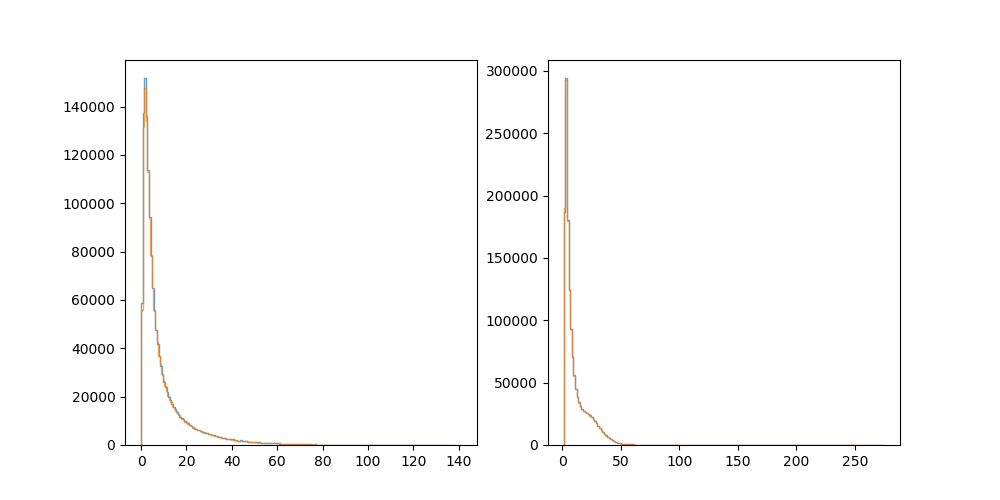

In [21]:
bins = 200
N = int(1.5e6)

fig, ax = plt.subplots(figsize=(10,5),ncols=2)
ax[0].hist(df.solidA,bins=bins,histtype='step',alpha=0.7);
ax[0].hist(sample(df.solidA,N),bins=bins,histtype='step',alpha=0.7);

ax[1].hist(df.sigma_pred,bins=bins,histtype='step',alpha=0.7);
ax[1].hist(sample(df.sigma_pred,N),bins=bins,histtype='step',alpha=0.7);

<IPython.core.display.Javascript object>


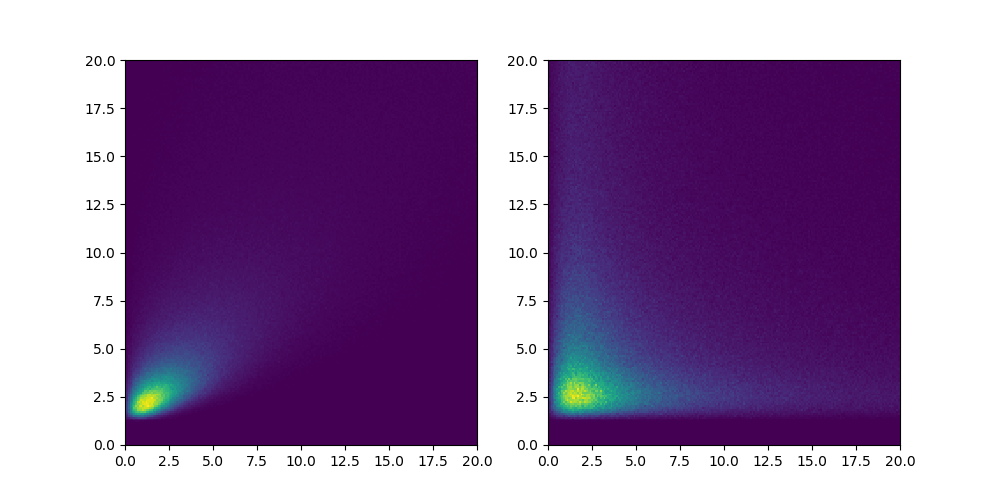

In [24]:
fig, ax = plt.subplots(figsize=(10,5),ncols=2)
ax[0].hist2d(df.solidA,df.sigma_pred,bins=bins, range=((0,20),(0,20)));
ax[1].hist2d(sample(df.solidA,N),sample(df.sigma_pred,N), bins=bins, range=((0,20),(0,20)));

In [25]:
def sample2d(df2d,N,noise=1):
    return df2d.sample(N,replace=True) + np.random.normal(0,noise,(N,2))

<IPython.core.display.Javascript object>


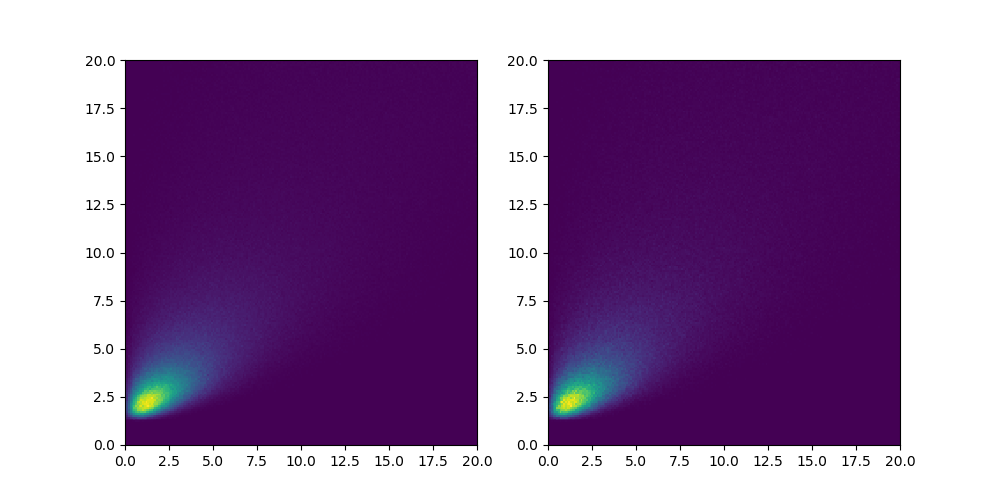

In [31]:
s = sample2d(df[['solidA','sigma_pred']],N,noise=0.01)

xlim = (0,20)
ylim = (0,20)

fig, ax = plt.subplots(figsize=(10,5),ncols=2)
ax[0].hist2d(df.solidA,df.sigma_pred,bins=bins,range=(xlim,ylim));
ax[1].hist2d(s.solidA,s.sigma_pred, bins=bins,range=(xlim,ylim));

# Moon simulation

In [32]:
def fan_out(x):
    N = x.shape[0]
    angles = np.random.random(N)*2*np.pi
    tmp = np.zeros((N,2,2))
    sin = np.sin(angles)
    cos = np.cos(angles)
    tmp[:,0,0] = cos
    tmp[:,0,1] = -sin
    tmp[:,1,0] = sin
    tmp[:,1,1] = cos
    xy = np.hstack([x.reshape(N,1),np.zeros((N,1))])
    return np.matmul(xy.reshape(N,1,2),tmp).reshape(N,2)

In [33]:
N = 40_000_000
xw = 40

signal = np.random.uniform(-xw,xw,(N,2))#(np.random.uniform((N,2)) - 0.5)*2*xw
r = np.sqrt(signal[:,0]**2 + signal[:,1]**2)
mask = (r > 0.5)&(r<xw)
signal = signal[mask]

<IPython.core.display.Javascript object>


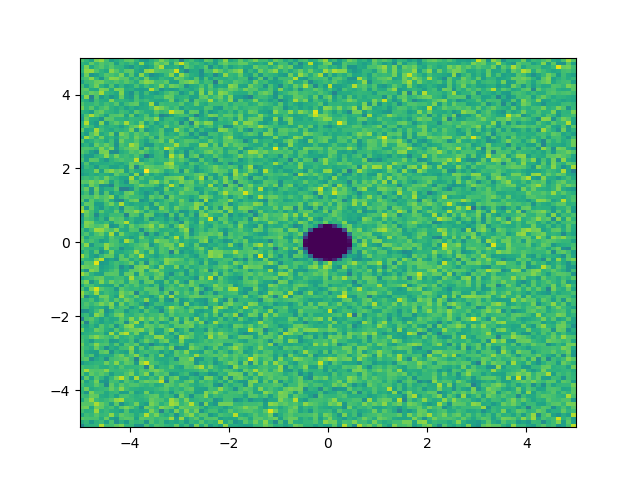

In [34]:
fig, ax = plt.subplots()
lim = 5
ax.hist2d(signal[:,0],signal[:,1],bins=100,range=((-lim,lim),(-lim,lim)));

In [35]:
N = signal.shape[0]
reco = signal.copy()
s = sample2d(df[['solidA','sigma_pred']],N,noise=0.001)
deviation = fan_out(s.solidA.to_numpy())
reco += deviation

<IPython.core.display.Javascript object>


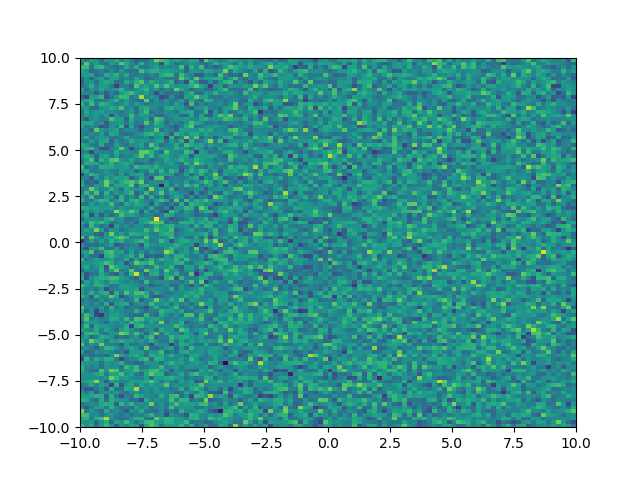

In [36]:
fig, ax = plt.subplots()

lim = 10
ax.hist2d(reco[:,0],reco[:,1],bins=100,range=((-lim,lim),(-lim,lim)));

<IPython.core.display.Javascript object>


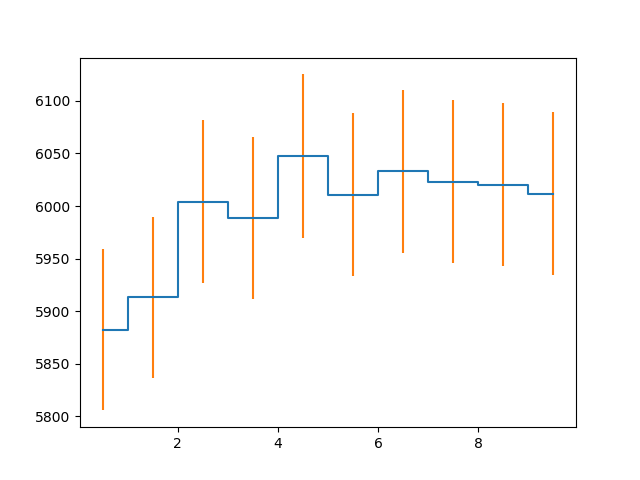

<ErrorbarContainer object of 3 artists>

In [39]:
r = np.sqrt(reco[:,0]**2 + reco[:,1]**2)
vals, binedges = np.histogram(r,bins=10,range=(0,lim))
vals = vals/(np.pi*(binedges[1:]**2 - binedges[:-1]**2))
bincenter = 0.5*(binedges[1:] + binedges[:-1])
# vals = vals/bincenter

fig, ax = plt.subplots()
ax.step(bincenter,vals,where='mid')
ax.errorbar(bincenter,vals,np.sqrt(vals),fmt='none')

# fig, ax = plt.subplots()
# ax.plot(np.quantile(1/(np.pi*np.sqrt(r)),np.linspace(0,1,100)),np.linspace(0,1,100))

# Cutting in sigma

In [200]:
N = signal.shape[0]
reco = signal.copy()
s = sample2d(df[df.sigma_pred <= 2][['solidA','sigma_pred']],N,noise=0.01)
deviation = fan_out(s.solidA.to_numpy())
reco += deviation

<IPython.core.display.Javascript object>


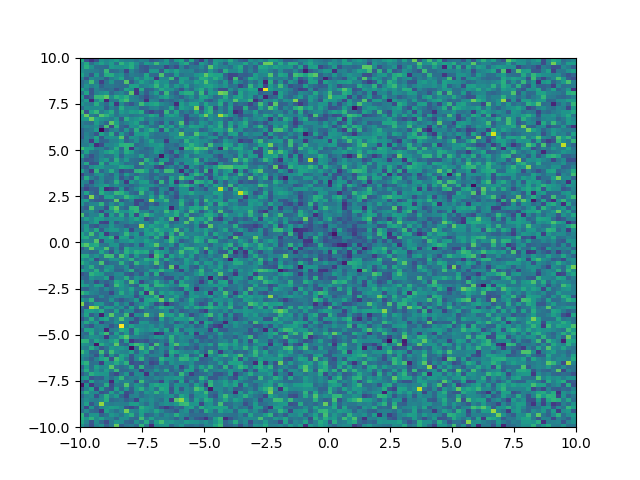

In [117]:
fig, ax = plt.subplots()

lim = 10
ax.hist2d(reco[:,0],reco[:,1],bins=100,range=((-lim,lim),(-lim,lim)));

In [149]:
r.shape, ((r+dr)**2 - (r-dr)**2).shape

((31411740,), (31411740,))

In [158]:
# dr = 0.005
# a = np.quantile(r/(np.pi*((r+dr)**2 - (r-dr)**2)),np.linspace(0,1,100))
a = np.quantile(r,np.linspace(0,1,100)**2)

In [169]:
a/(np.pi*((a+dr)**2 - (a-dr)**2))

array([15.91549431, 15.91549431, 15.91549431, 15.91549431, 15.91549431,
       15.91549431, 15.91549431, 15.91549431, 15.91549431, 15.91549431,
       15.91549431, 15.91549431, 15.91549431, 15.91549431, 15.91549431,
       15.91549431, 15.91549431, 15.91549431, 15.91549431, 15.91549431,
       15.91549431, 15.91549431, 15.91549431, 15.91549431, 15.91549431,
       15.91549431, 15.91549431, 15.91549431, 15.91549431, 15.91549431,
       15.91549431, 15.91549431, 15.91549431, 15.91549431, 15.91549431,
       15.91549431, 15.91549431, 15.91549431, 15.91549431, 15.91549431,
       15.91549431, 15.91549431, 15.91549431, 15.91549431, 15.91549431,
       15.91549431, 15.91549431, 15.91549431, 15.91549431, 15.91549431,
       15.91549431, 15.91549431, 15.91549431, 15.91549431, 15.91549431,
       15.91549431, 15.91549431, 15.91549431, 15.91549431, 15.91549431,
       15.91549431, 15.91549431, 15.91549431, 15.91549431, 15.91549431,
       15.91549431, 15.91549431, 15.91549431, 15.91549431, 15.91

<IPython.core.display.Javascript object>


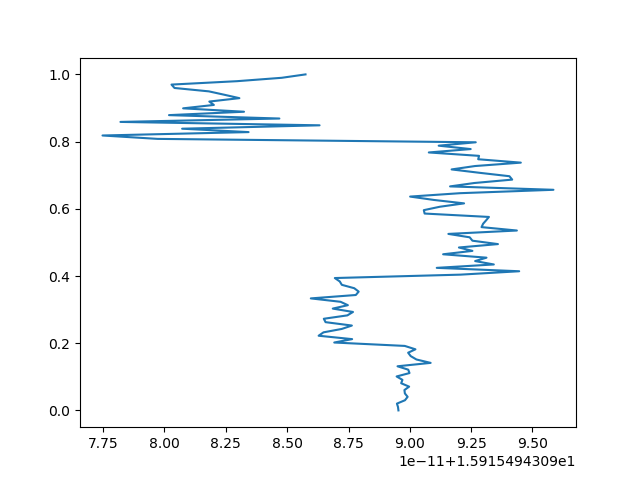

In [163]:
fig, ax = plt.subplots()

ax.plot(a/(np.pi*((a+dr)**2 - (a-dr)**2)),np.linspace(0,1,100))

<IPython.core.display.Javascript object>


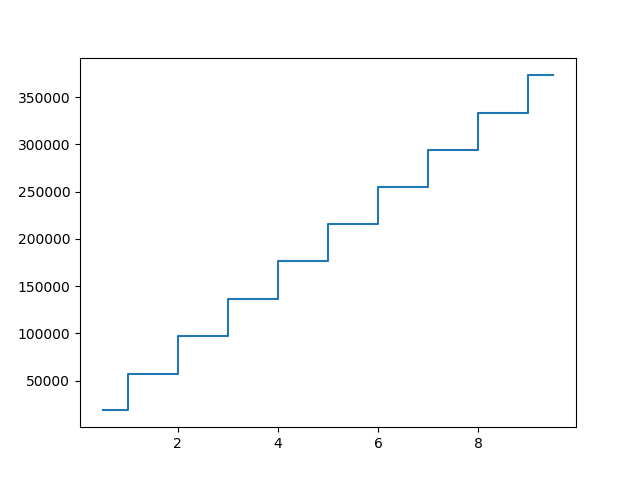

<IPython.core.display.Javascript object>


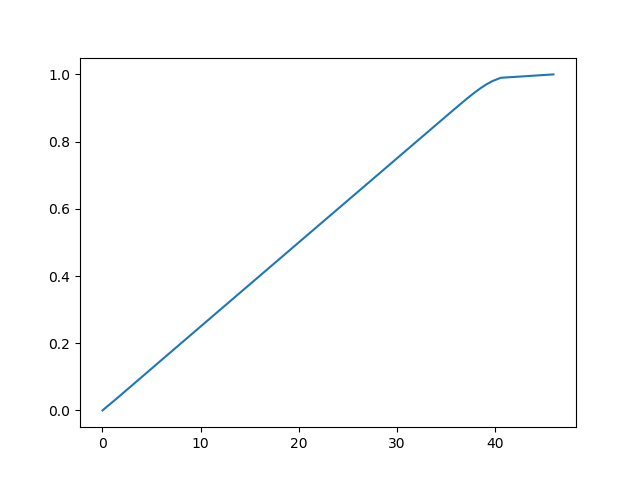

In [134]:
r = np.sqrt(reco[:,0]**2 + reco[:,1]**2)
vals, binedges = np.histogram(r,bins=10,range=(0,lim))
vals = vals/(np.pi*(binedges[1:]**2 - binedges[:-1]**2))
bincenter = 0.5*(binedges[1:] + binedges[:-1])
# vals = vals/bincenter

fig, ax = plt.subplots()
ax.step(bincenter,vals,where='mid')
ax.errorbar(bincenter,vals,np.sqrt(vals),fmt='none')
# ax.hist(r,bins=100,range=(0,xf));

fig, ax = plt.subplots()

ax.plot(np.quantile(r,np.square(np.linspace(0,1,100))),np.linspace(0,1,100))

# Investigate correlation between solidA and azimuth/zenith

In [380]:
from tqdm import tqdm

d = (df.azimuth.max() - df.azimuth.min())/50
azs = np.arange(0,df.azimuth.max()+d,d)
zes = np.arange(0,df.zenith.max()+d/2,d/2)

h = np.zeros((azs.shape[0],zes.shape[0]))
for row, az in enumerate(tqdm(azs)):
    for col, ze in enumerate(zes):
        r = ((df.azimuth - az)**2 + (df.zenith - ze)**2)
        w = (1+r/d**2)**(-2)#np.exp(-2/d*r)
        h[row,col] = (w*df.solidA).sum()/w.sum()

100%|██████████████████████████████████████████| 52/52 [00:28<00:00,  1.81it/s]


<IPython.core.display.Javascript object>


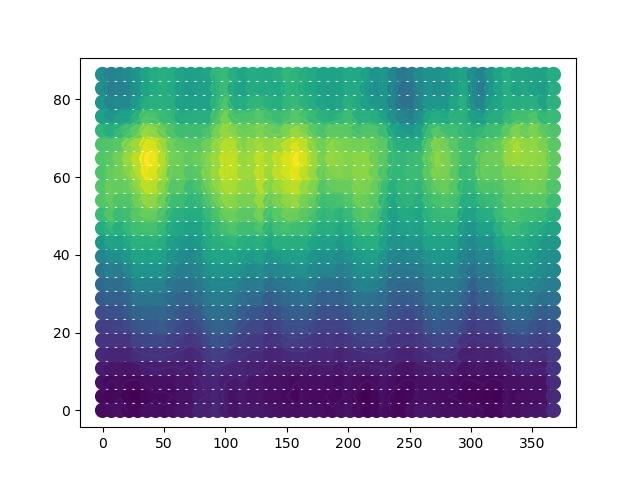

In [381]:
fig, ax = plt.subplots()
ax.scatter(*np.meshgrid(azs,zes),c=h.T,s=100)
ax.contour(*np.meshgrid(azs,zes),h.T,levels=20)

<IPython.core.display.Javascript object>


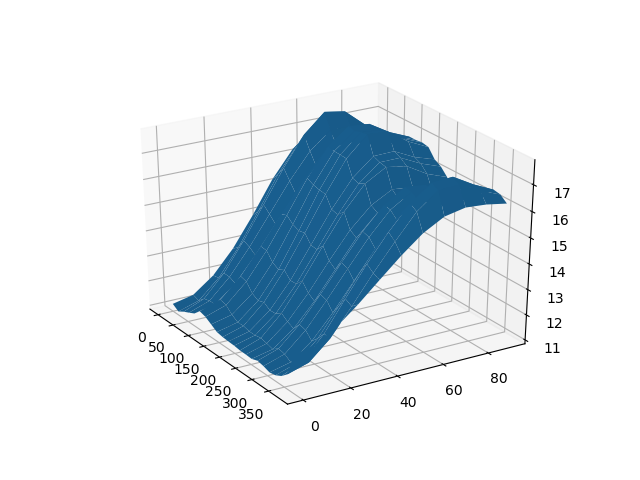

In [344]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

ax.plot_surface(*np.meshgrid(azs,zes),h.T)

# ax.scatter(xs = df.azimuth.to_numpy(),ys = df.zenith.to_numpy(),zs = df.solidA.to_numpy())

<IPython.core.display.Javascript object>


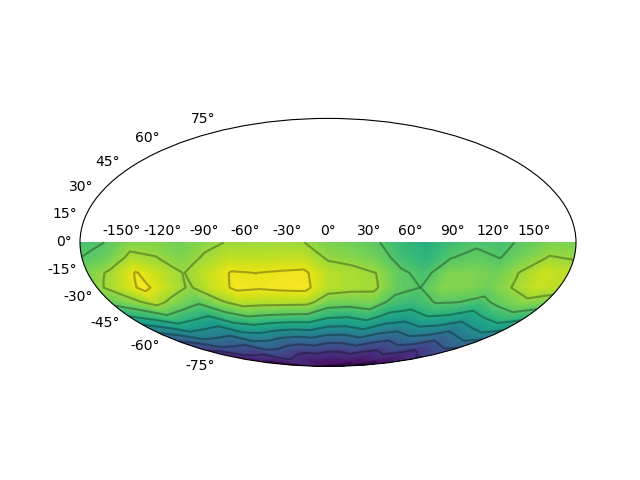

In [373]:
plt.figure()
ax = plt.subplot(111, projection = 'mollweide')
ax.contourf(*np.meshgrid((azs-180)*np.pi/180,(zes-180/2)*np.pi/180),h.T,100)
ax.contour(*np.meshgrid((azs-180)*np.pi/180,(zes-180/2)*np.pi/180),h.T,10,colors='k',alpha=0.3)

<IPython.core.display.Javascript object>


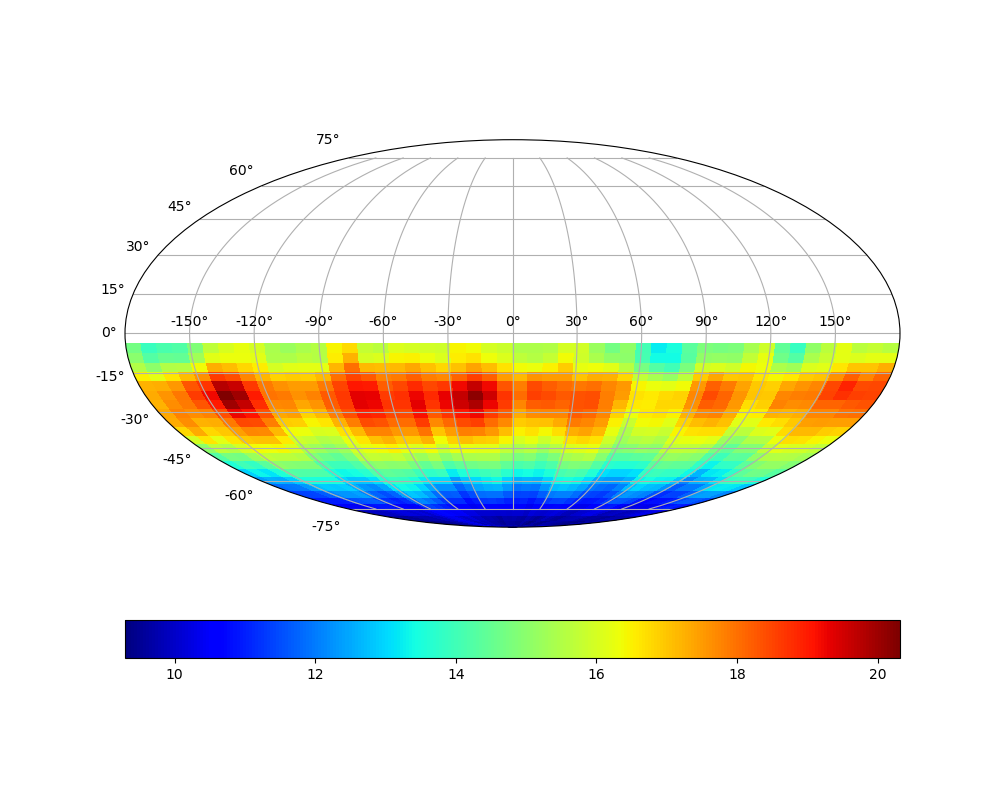

In [382]:
fig, ax = plt.subplots(subplot_kw=dict(projection='mollweide'), figsize=(10,8))
im = ax.pcolormesh(*np.meshgrid((azs-180)*np.pi/180,(zes-180/2)*np.pi/180),h.T,cmap=cm.jet)#For example,using as cmap="Spectral",cmap="seismic",cmap="coolwarm" as other alternatives
# ax.set_title('real$(Y^2_ 4)$', fontsize=20,fontweight='bold')
# plt.xlabel(r'$\phi$',fontsize=20)#Italic font method
# plt.ylabel(r'$\mathbf{\theta}$',fontsize=20)#Bold font method without fontweight parameters
ax.grid()
fig.colorbar(im, orientation='horizontal');
# plt.show(fig)

# Fitting uncertain data with likelihood:

In [2]:
def gauss(x,mu,sigma):
    x = np.asarray(x).reshape(-1,1)
    mu = np.expand_dims(mu,0)
    sigma = np.expand_dims(sigma,0)
    return np.exp(-0.5*((x-mu)/sigma)**2)/(sigma*np.sqrt(2*np.pi))#).squeeze()
# gauss = np.vectorize(gauss)

In [3]:
gauss(np.linspace(-2,5,5),np.linspace(-2,5,1),np.ones(1))

array([[3.98942280e-01],
       [8.62773188e-02],
       [8.72682695e-04],
       [4.12847099e-07],
       [9.13472041e-12]])

In [4]:
from scipy.integrate import quad, quad_vec
from scipy.optimize import minimize

N = 6

sigmas = np.random.normal(6,1.2,N)
mus = np.random.normal(5,10,N)

<IPython.core.display.Javascript object>


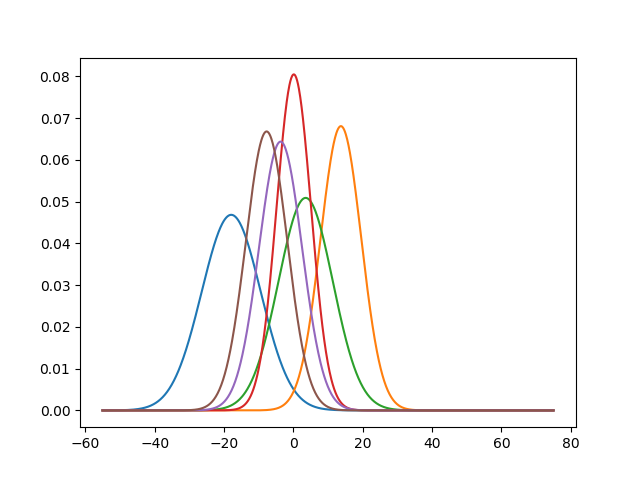

In [17]:
minimum = -55
maximum = 75
x = np.linspace(minimum,maximum,1000)

fig, ax = plt.subplots()
ax.plot(x,gauss(x,mus,sigmas));

In [21]:
from iminuit import Minuit
from iminuit.util import make_func_code
from iminuit import describe

class integratedLH:
    def __init__(self, f):
        self.f = f
        
        self.func_code = make_func_code(describe(self.f))
    
    def __call__(self, *par):
        return self.f(*par)
    
    def default_errordef(self):
        return 0.5

def log_gauss(x,mu,sigma):
    x = np.asarray(x).reshape(-1,1)
    mu = np.expand_dims(mu,0)
    sigma = np.expand_dims(sigma,0)
    return -0.5*((x-mu)/sigma)**2 - np.log(sigma*np.sqrt(2*np.pi)+1e-7)

def LossFunc(mu, sigma):
    return -quad(lambda x: log_gauss(x,mu,sigma)*(gauss(x,mus,sigmas).sum(1)),x.min(),x.max())[0]    

def LossFunc2(mu,sigma):
    return -np.sum(np.log(quad_vec(lambda x: gauss(x,mu,sigma)*gauss(x,mus,sigmas),*(x.min(),x.max()))[0]))

# obj = integratedLH(LossFunc)
# M = Minuit(obj,mu=5,sigma=1)

In [22]:
import timeit
obj = integratedLH(LossFunc)
M = Minuit(obj,mu=5,sigma=10)
# print(timeit.timeit(M.migrad,number=10))
M.migrad()

------------------------------------------------------------------
| FCN = 23.33                   |      Ncalls=33 (33 total)      |
| EDM = 7.93e-08 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
-------------------------------------------------------------------------------------------
|   | Name  |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
-------------------------------------------------------------------------------------------
| 0 | mu    |    -2     |     5     |            |            |         |         |       |
| 1 | sigma |   11.8    |    3.4    |            |            |         |         |       |
-------------------------------------------------------------------------------------------

In [23]:
obj2 = integratedLH(LossFunc2)
M2 = Minuit(obj2,mu=5,sigma=10, limit_sigma =(0.0001,None))
# print(timeit.timeit(M.migrad,number=10))
M2.migrad()

------------------------------------------------------------------
| FCN = 21.95                   |      Ncalls=43 (43 total)      |
| EDM = 3.6e-07 (Goal: 0.0001)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
-------------------------------------------------------------------------------------------
|   | Name  |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
-------------------------------------------------------------------------------------------
| 0 | mu    |    -1     |     4     |            |            |         |         |       |
| 1 | sigma |     6     |     4     |            |            |         |         |       |
-------------------------------------------------------------------------------------------

<IPython.core.display.Javascript object>


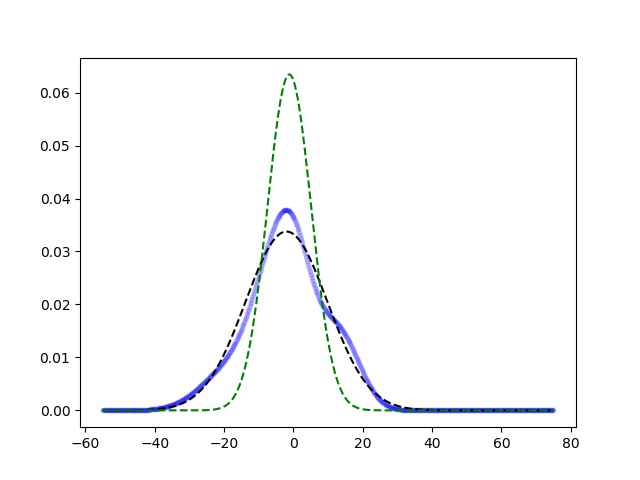

In [24]:
fig, ax = plt.subplots()
ax.plot(x,gauss(x,*M.args),'k--')
ax.plot(x,gauss(x,*M2.args),'g--')
ax.plot(x,gauss(x,mus,sigmas).mean(1),'b.',zorder=-1,alpha=0.1)

In [417]:
def integrate(mu,sigma):
    return -quad(lambda x: gauss(x,mu,sigma)*(gauss(x,mu1,s1) + gauss(x,mu2,s2)),-2,5)[0]
integrate = np.vectorize(integrate)

In [421]:
L = integrate(x,np.ones(1000))

In [423]:
L2 = integrate(np.ones(20)*1.42,np.linspace(0.1,10,20))

In [443]:
m = minimize(loss,m.x)

# Fitting 2d Gaussian to simulated reconstruction with uncertainties

In [79]:
alpha = 2
lim = 4
mask = (reco[:,0] >= -alpha*lim)&(reco[:,1] >= -alpha*lim)&(reco[:,0] <= alpha*lim)&(reco[:,1] <= alpha*lim)
# mask = (signal[:,0] >= -alpha*lim)&(signal[:,1] >= -alpha*lim)&(signal[:,0] <= alpha*lim)&(signal[:,1] <= alpha*lim)
xy_reco = reco[mask]
xy_sigma = s.sigma_pred[mask].to_numpy()

In [80]:
# mask = [0,1,2,3,4,5]
mask = np.random.randint(0,xy_reco.shape[0],200000)

<IPython.core.display.Javascript object>


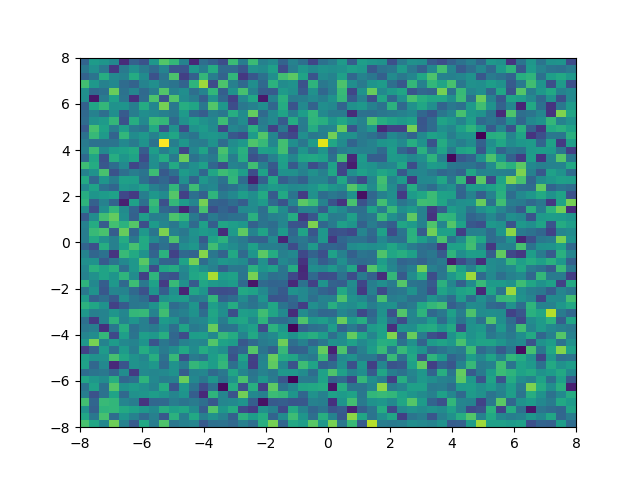

<IPython.core.display.Javascript object>


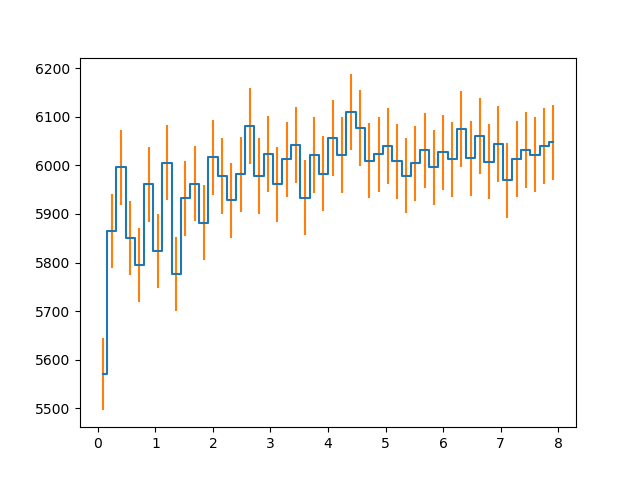

<ErrorbarContainer object of 3 artists>

In [81]:
fig, ax = plt.subplots()

lim = lim*alpha
ax.hist2d(xy_reco[:,0],xy_reco[:,1],bins=50,range=((-lim,lim),(-lim,lim)));

vals, binedges = np.histogram(r,bins=50,range=(0,lim))
vals = vals/(np.pi*(binedges[1:]**2 - binedges[:-1]**2))
bincenter = 0.5*(binedges[1:] + binedges[:-1])
# vals = vals/bincenter

fig, ax = plt.subplots()
ax.step(bincenter,vals,where='mid')
ax.errorbar(bincenter,vals,np.sqrt(vals),fmt='none')

<IPython.core.display.Javascript object>


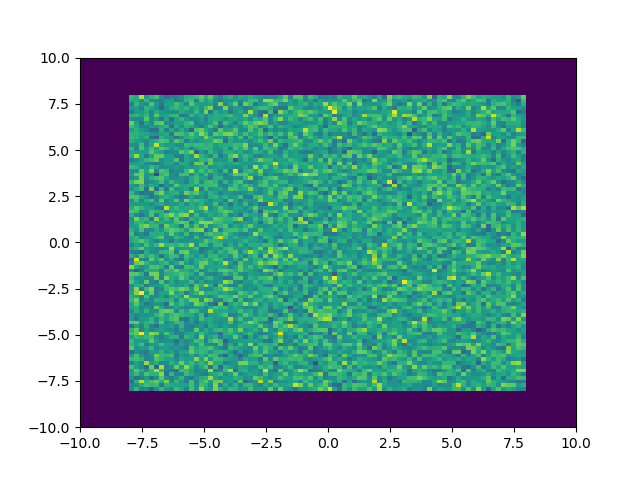

In [82]:
fig, ax = plt.subplots()

lim = 10
ax.hist2d(xy_reco[mask,0],xy_reco[mask,1],bins=100,range=((-lim,lim),(-lim,lim)));

<IPython.core.display.Javascript object>


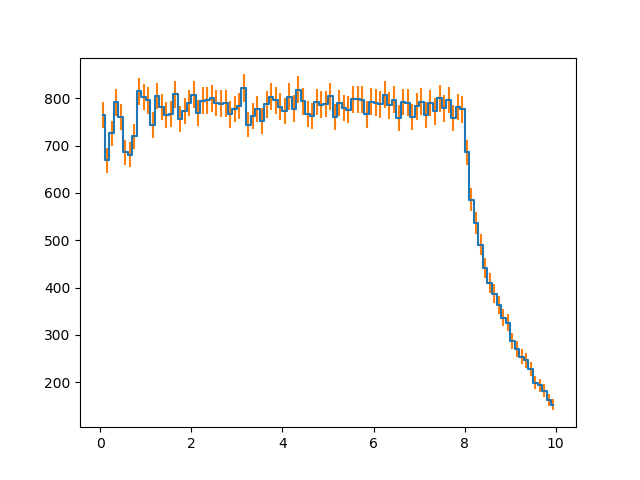

<ErrorbarContainer object of 3 artists>

In [83]:
r = np.sqrt(xy_reco[mask,0]**2 + xy_reco[mask,1]**2)
vals, binedges = np.histogram(r,bins=100,range=(0,lim))
vals = vals/(np.pi*(binedges[1:]**2 - binedges[:-1]**2))
bincenter = 0.5*(binedges[1:] + binedges[:-1])
# vals = vals/bincenter

fig, ax = plt.subplots()
ax.step(bincenter,vals,where='mid')
ax.errorbar(bincenter,vals,np.sqrt(vals),fmt='none')

In [39]:
import timeit
def f():
    return dblquad(lambda x,y: x*y, 0,1,0,1)
def f2():
    return quad(lambda x: quad(lambda y: x*y,0,1)[0],0,1)
print(timeit.timeit(f,number=5000))
print(timeit.timeit(f2,number=5000))

1.3528576999999586
0.7810155000000805


In [26]:
from scipy.integrate import dblquad
from numba import jit
import time

def gauss(x,mu,sigma):
    x = np.asarray(x).reshape(-1,1)
    mu = np.expand_dims(mu,0)
    sigma = np.expand_dims(sigma,0)
    return np.exp(-0.5*((x-mu)/sigma)**2)/(sigma*np.sqrt(2*np.pi))#).squeeze()

def gauss2d(x,y,mus,sigmas):
    xy = (np.vstack((x,y,)).T).reshape(-1,2,1)
    mus = mus.T.reshape(1,2,-1)
    sigmas = sigmas.reshape(1,-1)

    z_sqrd = (((xy - mus)/sigmas)**2).sum(1)
    return np.exp(-0.5*z_sqrd)/(2*np.pi*sigmas**2)

def log_gauss2d(x,y,mu_x,mu_y,sigma):
    z_sqrd = ((x-mu_x)**2 + (y - mu_y)**2)/ sigma**2
    return -0.5*z_sqrd - np.log(2*np.pi*sigma**2 + 1e-7)

def loss(x,y,mu_x,mu_y,sigma,f):
    z_sqrd = ((x-mu_x)**2 + (y - mu_y)**2)/ sigma**2
    return np.log(1 - f*np.exp(-0.5*z_sqrd)/(2*np.pi*sigma**2))
    
def LossFunc(mu_x,mu_y,sigma):
#     print(time.time(), 'called')
    return -dblquad(lambda x,y: loss(x,y,mu_x,mu_y,sigma)*(gauss2d(x,y,xy_reco[mask],xy_sigma[mask]).sum(1)),-lim,lim,-lim,lim)[0]    

def LossFunc2(mu_x,mu_y,sigma):
    print(mu_x,mu_y,np.append(mu_x,mu_y))
#     print(time.time(), 'called')
#     return -dblquad(lambda x,y: loss(x,y,mu_x,mu_y,sigma)*(gauss2d(x,y,xy_reco[mask],xy_sigma[mask]).sum(1)),-lim,lim,-lim,lim)[0]    
    return -np.sum(np.log(quad_vec(lambda y: quad_vec(lambda x: (1-gauss2d(x,y,np.append(mu_x,mu_y),np.asarray(sigma)))*(gauss2d(x,y,xy_reco[mask],xy_sigma[mask])),-lim,lim)[0],-lim,lim)[0]))

def binc(x):
    return 0.5*(x[1:] + x[:-1])

In [61]:
obj = integratedLH(LossFunc)
M = Minuit(obj,mu_x=1,mu_y=1,sigma=1, limit_mu_x=(-2,2),limit_mu_y=(-2,2),limit_sigma=(0,None))
M.migrad()

------------------------------------------------------------------
| FCN = 0.02875                 |     Ncalls=106 (106 total)     |
| EDM = 2.7e-07 (Goal: 0.0001)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
-------------------------------------------------------------------------------------------
|   | Name  |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
-------------------------------------------------------------------------------------------
| 0 | mu_x  |   -1.8    |    2.4    |            |            |   -2    |    2    |       |
| 1 | mu_y  |    0.6    |    3.2    |            |            |   -2    |    2    |       |
| 2 | sigma |   110.7   |    1.4    |            |            |    0    |         |       |
-------------------------------------------------------------------------------------------

In [ ]:
obj2 = integratedLH(LossFunc2)
M2 = Minuit(obj2,mu_x=1,mu_y=1,sigma=1, limit_mu_x=(-2,2),limit_mu_y=(-2,2),limit_sigma=(0,None))
M2.migrad()

1.0 1.0 [1. 1.]


<IPython.core.display.Javascript object>


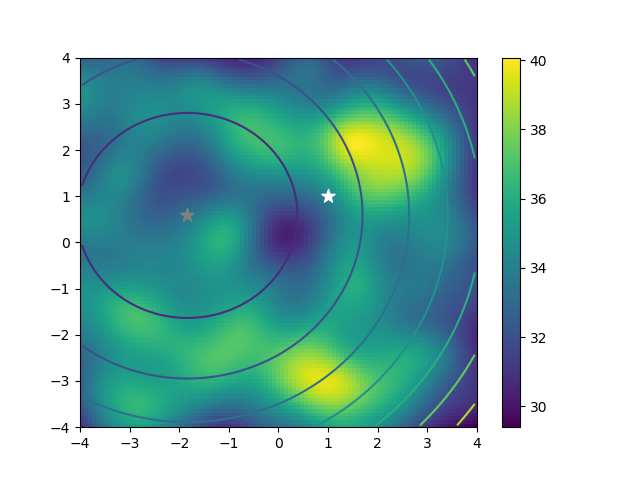

In [62]:
n = 100
X_grid,Y_grid = np.meshgrid(np.linspace(-lim,lim,n),np.linspace(-lim,lim,n))
X,Y = np.meshgrid(binc(np.linspace(-lim,lim,n)),binc(np.linspace(-lim,lim,n)))

h = gauss2d(X.flatten(),Y.flatten(),xy_reco[mask],xy_sigma[mask]).sum(1)
h_loss = loss(X.flatten(),Y.flatten(),*M.args)

fig, ax = plt.subplots()
im = ax.pcolormesh(X_grid,Y_grid,h.reshape(n-1,n-1),shading='flat')
# ax.scatter(xy_reco[mask,0],xy_reco[mask,1],s = 1000*xy_sigma[mask],alpha=0.5)
ax.contour(X,Y,h_loss.reshape(n-1,n-1))
ax.scatter(1,1,c='w',marker='*',s=100,zorder=10)
ax.scatter(M.args[0],M.args[1],c='grey',marker='*',s=100,zorder=10)
# ax.scatter(X.flatten(),Y.flatten(),s=1,c=h)
fig.colorbar(im)

# Vastly faster method, and would scale well with increase in simulated points:

In [85]:
N_samples = 2**8 + 1

int_lim = 4

x_grid = np.linspace(-int_lim,int_lim,N_samples + 1)
y_grid = x_grid.copy()

X_grid, Y_grid = np.meshgrid(x_grid,y_grid)

x = binc(x_grid)
y = x.copy()

X, Y = np.meshgrid(x,y)

from scipy.integrate import simps, romb, quad_vec
dx = (x[1:] - x[:-1]).mean()
dy = (y[1:] - y[:-1]).mean()

In [86]:
from tqdm import tqdm
# P_i = gauss2d(X.flatten(),Y.flatten(),xy_reco[mask],xy_sigma[mask])
# P_i2 = P_i.sum(1)

P_i2 = np.zeros(N_samples**2)

subsample = 5000
for i in tqdm(range(0,xy_reco[mask].shape[0],subsample)):
    P_i2 += gauss2d(X.flatten(),Y.flatten(),xy_reco[mask][i:i+subsample],xy_sigma[mask][i:i+subsample]).sum(1)

100%|██████████████████████████████████████████| 40/40 [12:53<00:00, 19.34s/it]


In [87]:
from time import time

# start = time()
# def LossFunc(mu_x,mu_y,sigma):
#     print(f"{time() - start} - mu_x: {mu_x}, mu_y: {mu_y}")
#     P = (1-gauss2d(X.flatten(),Y.flatten(),np.asarray([mu_x,mu_y]),np.asarray(sigma)))*P_i
#     return -np.log(romb(romb(P.reshape(N_samples,N_samples,-1),dy,0),dx,0)).sum(0)

def LossFunc2(mu_x,mu_y,sigma,f):
    z_sqrd = ((X.flatten()-mu_x)**2 + (Y.flatten() - mu_y)**2)/ sigma**2
    P = np.log(1/(4*int_lim**2 - f*sigma**2*2*np.pi)*(1 - f*np.exp(-0.5*z_sqrd)))*P_i2
    return -romb(romb(P.reshape(N_samples,N_samples,-1),dy,0),dx,0)

In [42]:
obj = integratedLH(LossFunc)
M = Minuit(obj,mu_x=0,mu_y=0,sigma=1, limit_mu_x=(-int_lim,int_lim),limit_mu_y=(-int_lim,int_lim),limit_sigma=(0,None))

In [43]:
start = time()
M.migrad()

0.0 - mu_x: 0.0, mu_y: 0.0
1.8067314624786377 - mu_x: 0.009686187441197536, mu_y: 0.0
3.643061399459839 - mu_x: -0.009686187441197536, mu_y: 0.0
5.508722305297852 - mu_x: 0.023097815612806993, mu_y: 0.0
7.426325798034668 - mu_x: -0.02309781561280655, mu_y: 0.0
9.31353759765625 - mu_x: 0.0, mu_y: 0.009686187441197536
11.259907722473145 - mu_x: 0.0, mu_y: -0.009686187441197536
13.211005210876465 - mu_x: 0.0, mu_y: 0.022613574771507494
15.167474508285522 - mu_x: 0.0, mu_y: -0.022613574771507494
17.13309931755066 - mu_x: 0.0, mu_y: 0.0
18.940672636032104 - mu_x: 0.0, mu_y: 0.0
20.95912766456604 - mu_x: 0.0, mu_y: 0.0
22.84090566635132 - mu_x: 0.0, mu_y: 0.0
24.700616598129272 - mu_x: 0.013662056956500024, mu_y: 0.02611350048075689
26.63990807533264 - mu_x: 0.011197335594517632, mu_y: 0.02140252450531488
28.603026866912842 - mu_x: 0.03675091700259436, mu_y: 0.02611350048075689
30.48328709602356 - mu_x: -0.009427612389007578, mu_y: 0.02611350048075689
32.40580868721008 - mu_x: 0.013662056956

230.35634064674377 - mu_x: 0.12766572676920118, mu_y: 0.1516395295654398
232.30395483970642 - mu_x: 0.12378658327049052, mu_y: 0.1516395295654398
234.29766249656677 - mu_x: 0.14511913258218812, mu_y: 0.1516395295654398
236.34562969207764 - mu_x: 0.10632796560544122, mu_y: 0.1516395295654398
238.3546130657196 - mu_x: 0.12572618134242308, mu_y: 0.1531486872701615
240.42702960968018 - mu_x: 0.12572618134242308, mu_y: 0.15013033338725412
242.46318578720093 - mu_x: 0.12572618134242308, mu_y: 0.16672931213185382
244.39624905586243 - mu_x: 0.12572618134242308, mu_y: 0.13654589966068897
246.34891390800476 - mu_x: 0.12572618134242308, mu_y: 0.1516395295654398
248.3853361606598 - mu_x: 0.12572618134242308, mu_y: 0.1516395295654398
250.407555103302 - mu_x: 0.12572618134242308, mu_y: 0.1516395295654398
252.40290093421936 - mu_x: 0.12572618134242308, mu_y: 0.1516395295654398
254.33899021148682 - mu_x: 0.12572618134242308, mu_y: 0.1516395295654398
256.2853298187256 - mu_x: 0.14511913258218812, mu_y:

------------------------------------------------------------------
| FCN = 1.961e+04               |     Ncalls=136 (136 total)     |
| EDM = 1.01e-05 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     True      |     True      |   False   |   False   | False  |
------------------------------------------------------------------
-------------------------------------------------------------------------------------------
|   | Name  |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
-------------------------------------------------------------------------------------------
| 0 | mu_x  | 1.2573e-1 | 0.0000e-1 |            |            |   -3    |    3    |       |
| 1 | mu_y  | 1.5164e-1 | 0.0000e-1 |            |            |   -3    |    3    |       |
| 2 | sigma | 6.8125e-5 | 0.0000e-5 |            |            |    0    |         |       |
-------------------------------------------------------------------------------------------

In [88]:
obj2 = integratedLH(LossFunc2)
M2 = Minuit(obj2,mu_x=0,mu_y=0,sigma=0.5,f=1, 
            limit_mu_x=(-int_lim,int_lim),limit_mu_y=(-int_lim,int_lim),limit_sigma=(0,None),limit_f=(0,1))
M2.migrad()

C:\Users\jv97\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


------------------------------------------------------------------
| FCN = 4.958e+04               |     Ncalls=223 (223 total)     |
| EDM = 4.96e+04 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   | False  |
------------------------------------------------------------------
-------------------------------------------------------------------------------------------
|   | Name  |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
-------------------------------------------------------------------------------------------
| 0 | mu_x  |     4     |     0     |            |            |   -4    |    4    |       |
| 1 | mu_y  |  -3.9507  |  0.0000   |            |            |   -4    |    4    |       |
| 2 | sigma | 1.1285e1  | 0.0000e1  |            |            |    0    |         |       |
| 3 | f     | 7.3097e-2 | 0.0000e-2 |            |            |    0    |    1    |       |
-------------------------------------------------------------------------------------------

In [89]:
M2.migrad()

C:\Users\jv97\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


------------------------------------------------------------------
| FCN = -2.103e+05              |     Ncalls=188 (411 total)     |
| EDM = -2.1e+05 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   | False  |
------------------------------------------------------------------
-------------------------------------------------------------------------------------------
|   | Name  |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
-------------------------------------------------------------------------------------------
| 0 | mu_x  |     4     |     0     |            |            |   -4    |    4    |       |
| 1 | mu_y  |  -3.9507  |  0.0000   |            |            |   -4    |    4    |       |
| 2 | sigma | 1.1805e1  | 0.0000e1  |            |            |    0    |         |       |
| 3 | f     | 7.3097e-2 | 0.0000e-2 |            |            |    0    |    1    |       |
-------------------------------------------------------------------------------------------

In [452]:
M2.values['mu_x']

NameError: name 'mu_x' is not defined

<IPython.core.display.Javascript object>


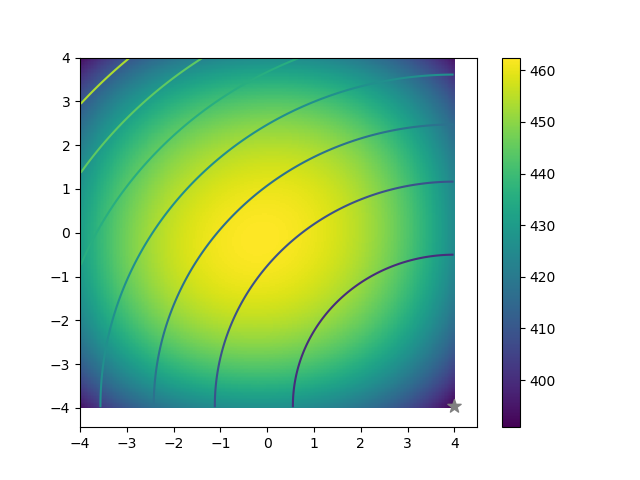

In [90]:
fig, ax = plt.subplots()

im = ax.pcolormesh(X_grid, Y_grid,P_i2.reshape(N_samples,N_samples))
# ax.scatter(1,1,c='w',marker='*',s=100,zorder=10)
ax.scatter(M2.args[0],M2.args[1],c='grey',marker='*',s=100,zorder=10)

h_loss = loss(X.flatten(),Y.flatten(),*M2.args)
ax.contour(X,Y,h_loss.reshape(N_samples,N_samples))

fig.colorbar(im)

<IPython.core.display.Javascript object>


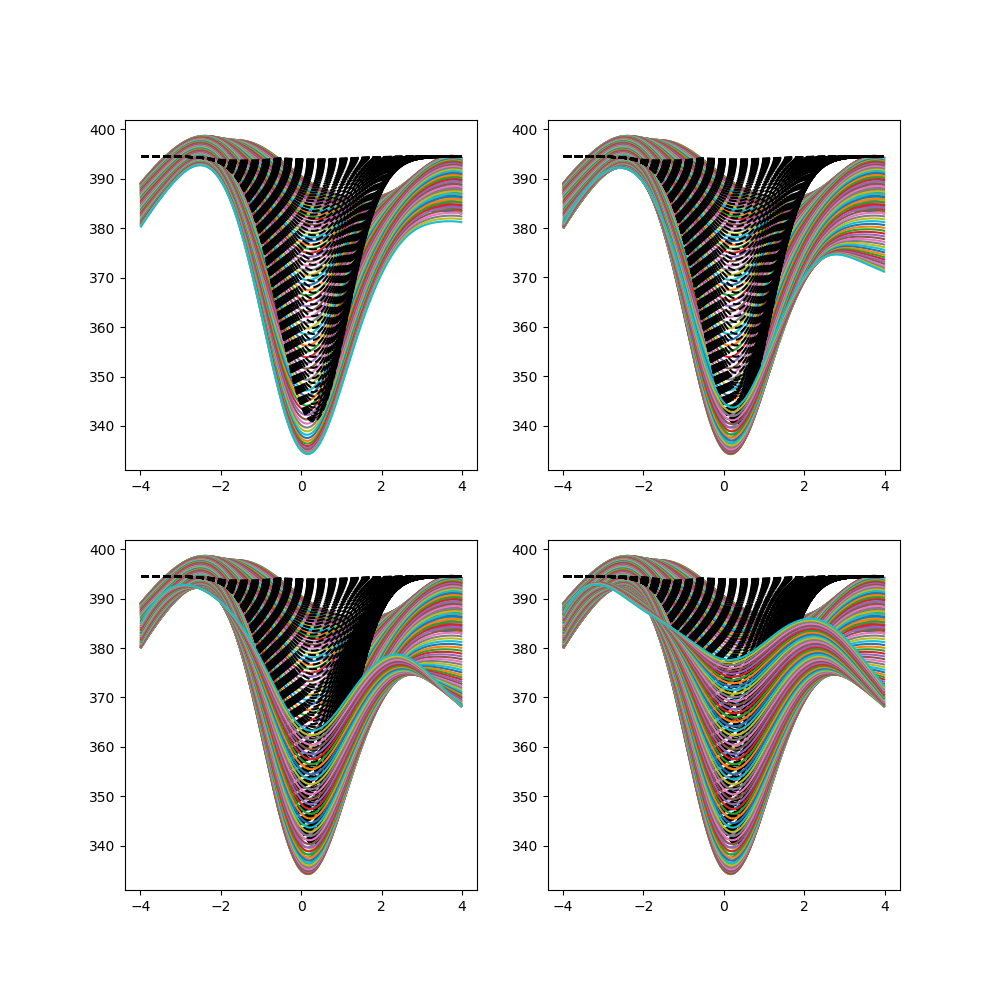

In [486]:
i = 130



fig, ax = plt.subplots(figsize=(10,10),ncols=2,nrows=2)
ax = ax.flatten()
for j in range(4):
    for i in range(50,130 + 20*j):

        z_sqrd = ((X[[Y[:,0] == y[i]][0]].flatten()-M2.values['mu_x'])**2 + (y[i] - M2.values['mu_y'])**2)/ M2.values['sigma']**2
        P = 1/(4*int_lim**2 - M2.values['f']*M2.values['sigma']**2*2*np.pi)*(1 - M2.values['f']*np.exp(-0.5*z_sqrd))*25000

        ax[j].plot(X[[Y[:,0] == y[i]][0]][0],P_i2.reshape(N_samples,N_samples)[Y[:,0] == y[i]][0])
        ax[j].plot(X[[Y[:,0] == y[i]][0]][0],P,'k--')

<IPython.core.display.Javascript object>


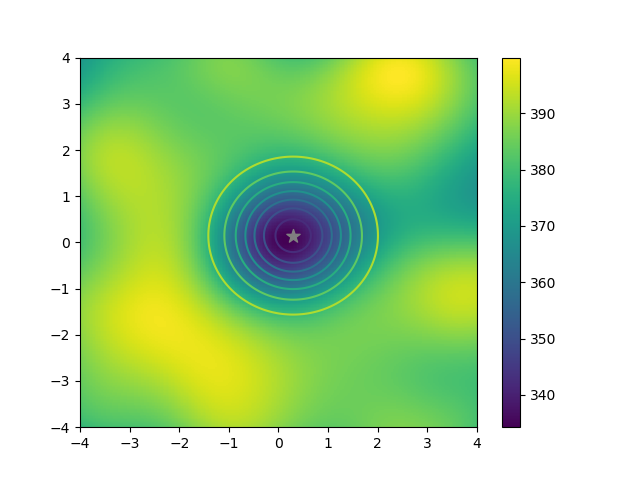

In [429]:
fig, ax = plt.subplots()

im = ax.pcolormesh(X_grid, Y_grid,P_i2.reshape(N_samples,N_samples))
# ax.scatter(1,1,c='w',marker='*',s=100,zorder=10)
ax.scatter(M2.args[0],M2.args[1],c='grey',marker='*',s=100,zorder=10)

h_loss = loss(X.flatten(),Y.flatten(),*M2.args)
ax.contour(X,Y,h_loss.reshape(N_samples,N_samples))

fig.colorbar(im)

# Below is experimantation on getting a working method for 2d inverse transform sampling (did not work)

<IPython.core.display.Javascript object>


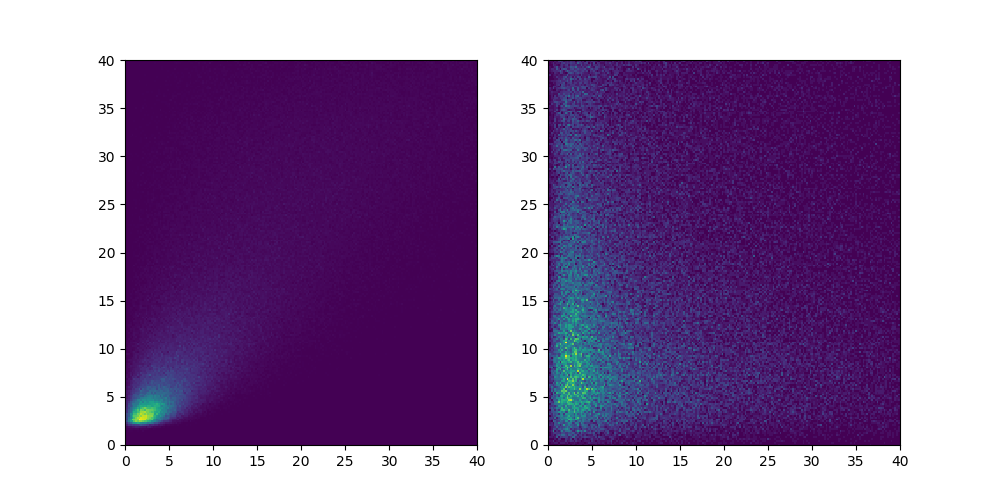

In [61]:
solidA_s = sample(df.solidA,300000)
sigma_s = sample(df.solidA*df.sigma_pred,300000)

xlim = (0,40)
ylim = (0,40)

fig, ax = plt.subplots(figsize=(10,5),ncols=2)
ax[0].hist2d(df.solidA,df.sigma_pred,bins=bins,range=(xlim,ylim));
ax[1].hist2d(solidA_s,sigma_s, bins=bins,range=(xlim,ylim));

In [27]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(df[['solidA','sigma_pred']])
vecs = pca.components_
varis = pca.explained_variance_
vecs, varis

(array([[ 0.75331482,  0.65766008],
        [ 0.65766008, -0.75331482]]),
 array([322.45896744,  44.25096527]))

In [54]:
theta = np.arctan(vecs[0,1]/vecs[0,0])
R = np.array([[np.cos(theta),np.sin(theta)],[-np.sin(theta),np.cos(theta)]]) #R_inverse = R.T
# r=(R@(df[['solidA','sigma_pred']]@R.T).T).T
r= df[['solidA','sigma_pred']]@R.T

<IPython.core.display.Javascript object>


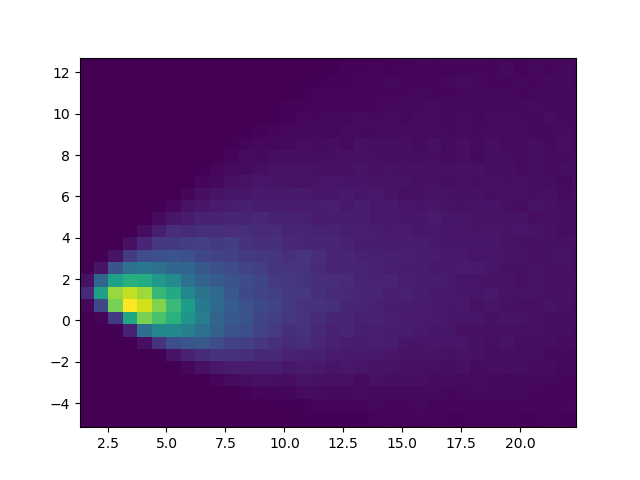

In [55]:
fig, ax = plt.subplots()
ax.hist2d(r.iloc[:,0],r.iloc[:,1],bins=bins);

In [62]:
x = sample(r.iloc[:,0],300000)
y = sample(r.iloc[:,1],300000)

In [84]:
s = np.vstack([x,y]).T@R

In [105]:
def draw_contour(x,y,ax,levels,cmap=None,bins=bins,range=(xlim,ylim)):
    val, x, y = np.histogram2d(x,y,bins=bins,range=range)
    x = 0.5*(x[1:] + x[:-1])
    y = 0.5*(y[1:] + y[:-1])
    
    ax.contour(*np.meshgrid(x,y),val,levels=levels,cmap=cmap)

<IPython.core.display.Javascript object>


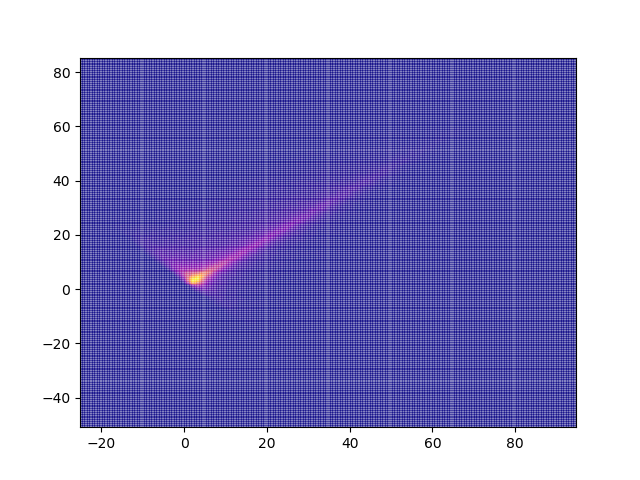

In [132]:
fig, ax = plt.subplots()

# draw_contour(s[:,0],s[:,1],ax,levels=5,bins=100,range=None)
# draw_contour(df.solidA,df.sigma_pred,ax,levels=5,bins=100,range=None,cmap='plasma')

ax.hist2d(s[:,0],s[:,1],bins=bins,range=None,alpha=0.5,cmap='plasma');
# ax.hist2d(df.solidA,df.sigma_pred,bins=bins,range=(xlim,ylim),alpha=0.1);

In [126]:
np.meshgrid(x,y)

[array([[ 0. ,  0.2,  0.4, ..., 39.6, 39.8, 40. ],
        [ 0. ,  0.2,  0.4, ..., 39.6, 39.8, 40. ],
        [ 0. ,  0.2,  0.4, ..., 39.6, 39.8, 40. ],
        ...,
        [ 0. ,  0.2,  0.4, ..., 39.6, 39.8, 40. ],
        [ 0. ,  0.2,  0.4, ..., 39.6, 39.8, 40. ],
        [ 0. ,  0.2,  0.4, ..., 39.6, 39.8, 40. ]]),
 array([[ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
        [ 0.2,  0.2,  0.2, ...,  0.2,  0.2,  0.2],
        [ 0.4,  0.4,  0.4, ...,  0.4,  0.4,  0.4],
        ...,
        [39.6, 39.6, 39.6, ..., 39.6, 39.6, 39.6],
        [39.8, 39.8, 39.8, ..., 39.8, 39.8, 39.8],
        [40. , 40. , 40. , ..., 40. , 40. , 40. ]])]

In [86]:
ax.hist2d(s[:,0],s[:,1],bins=bins,range=(xlim,ylim),alpha=0.5,cmap='plasma')

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 3., 3., 2.],
        [0., 0., 0., ..., 3., 3., 1.],
        [0., 0., 0., ..., 2., 2., 2.]]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,
         2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ,  4.2,
         4.4,  4.6,  4.8,  5. ,  5.2,  5.4,  5.6,  5.8,  6. ,  6.2,  6.4,
         6.6,  6.8,  7. ,  7.2,  7.4,  7.6,  7.8,  8. ,  8.2,  8.4,  8.6,
         8.8,  9. ,  9.2,  9.4,  9.6,  9.8, 10. , 10.2, 10.4, 10.6, 10.8,
        11. , 11.2, 11.4, 11.6, 11.8, 12. , 12.2, 12.4, 12.6, 12.8, 13. ,
        13.2, 13.4, 13.6, 13.8, 14. , 14.2, 14.4, 14.6, 14.8, 15. , 15.2,
        15.4, 15.6, 15.8, 16. , 16.2, 16.4, 16.6, 16.8, 17. , 17.2, 17.4,
        17.6, 17.8, 18. , 18.2, 18.4, 18.6, 18.8, 19. , 19.2, 19.4, 19.6,
        19.8, 20. , 20.2, 20.4, 20.6, 20.8, 21. , 21.2, 21.4, 21.6, 21.8,
        22.